In [1]:
from __future__ import division, print_function

import os
import sys
import csv
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

In [2]:
from xgboost import plot_importance, XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.feature_selection import SelectFromModel

In [3]:
warnings.filterwarnings("ignore")

In [4]:
## """ Read the data from the provided task_file """
## https://pandas.pydata.org/
task_file = ('./task_data.csv')
with open(task_file,mode='rb') as f:
    dataset = pd.read_csv(f)

## Check the data properties i.e. Identifying the important features within the provided data
### Benifits :
### 1.) help to concentrate on important features thus helping in building the model
### 2.) Get rid of features which are irrelavent and will not contribute to the model performance.

In [5]:
print(dataset.info())
print(dataset.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sample index  400 non-null    object 
 1   class_label   400 non-null    float64
 2   sensor0       400 non-null    float64
 3   sensor1       400 non-null    float64
 4   sensor2       400 non-null    float64
 5   sensor3       400 non-null    float64
 6   sensor4       400 non-null    float64
 7   sensor5       400 non-null    float64
 8   sensor6       400 non-null    float64
 9   sensor7       400 non-null    float64
 10  sensor8       400 non-null    float64
 11  sensor9       400 non-null    float64
dtypes: float64(11), object(1)
memory usage: 37.6+ KB
None
       class_label     sensor0     sensor1     sensor2     sensor3  \
count   400.000000  400.000000  400.000000  400.000000  400.000000   
mean      0.000000    0.523661    0.509223    0.481238    0.509752   
std       1.001252    0.

### Split data into training features and labels

In [6]:
## Extracting Labels from the data
Y = dataset['class_label']

In [7]:
## Extracting Features from the data
dataset.drop(['sample index','class_label'],axis=1,inplace=True)
X = dataset

## Creating a Correlation Matrix to check out the correlation between the sensors in the data

In [8]:
corr_matrix = dataset.corr()

## Heatmap of the correlation matrix

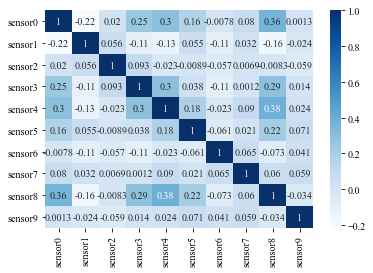

In [9]:
## https://seaborn.pydata.org/
sns.heatmap(corr_matrix, cmap='Blues', annot=True)
plt.show()
plt.close()

## split data into train and test dataset

In [10]:
## https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

## Defining the model to rank the sensors according to their importance/predictive power with respect to the class labels of the samples
### Testing the Accuracy and Efficiency of model

In [11]:
## https://www.kaggle.com/dansbecker/xgboost
## https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7
## https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [12]:
def model(model, model_name, X_train, y_train, X_test, y_test):
    """
    model :  classifier
        A model classifier to be used for study
    model_name: str
        Name of the classifier as a string
    X_train, y_train : data
        Training dataset from features and labels
    X_test, y_test : data
        Test dataset from features and labels
    """
    ## instantiate model
    model = model()

    ## Training model using training data set
    model.fit(X_train, y_train) 
    
    print('Model Feature Importance', model.feature_importances_)
    plt.bar(range(len(model.feature_importances_)),model.feature_importances_)
    plt.title(str(model_name))
    plt.xlabel('Sensors')
    plt.ylabel('Importance')
    plt.show()
    plt.close()
    
    if model_name == 'XGBClassifier':
        ## Visualizing the importance of each feature/sensor in the data set with their F-values.
        plot_importance(model,importance_type='gain')
        plt.show()
        plt.close()
    else:
        pass

    ## Ranking of sensors based on their importance value in a reverse order
    rank_sensors = sorted(zip(model.feature_importances_, X.columns), reverse=True)
    for label in rank_sensors:
        print(str(model_name) + ' For {} Predicitve Score is {}'.format(label[1], label[0]))

    ## Seperating features and their importance values
    scores = list(zip(*rank_sensors))[0]
    sensors = list(zip(*rank_sensors))[1]
    sensors_list = np.arange(len(sensors))

    ## Plot features with respect to their importance value
    sns.set()
    sns.set_style("whitegrid")
    fig = plt.figure(figsize=(8, 4))
    sns.barplot(sensors_list, np.array(scores), palette="flare")
    plt.xticks(sensors_list, sensors)
    plt.ylabel('Importance Score')
    plt.title(str(model_name))
    plt.show()
    plt.close()

#     ## Save ranked list of sensors and their importance values in a csv file
#     ranked_sensors = './'+str(model_name)+'_ranked_sensors.csv'
#     header = ['Sensor', 'Importance value']

#     with open(ranked_sensors,'w') as output:
#         ## create the csv writer
#         write = csv.writer(output)
#         ## write the header
#         write.writerow(header)
#         # write the row to csv file
#         write.writerows(zip(sensors, scores))
#     output.close()

    ## Evaluate the predicitions
    predictions = model.predict(X_test)

    ## Mean Absolute error
    print(str(model_name) + " Mean Absolute Error : " + str(mean_absolute_error(predictions, y_test)))

    ## Model Accuracy i.e how correct is the classifier?
    accuracy = accuracy_score(y_test, predictions)
    print(str(model_name) + ' Accuracy of Model is : %.2f%%'%(accuracy*100.0))

    ## Scalability with respect to numbers of features
    ## Fitting model using each importance as threshold
    ## https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/
  
    thresholds = np.sort(model.feature_importances_)
    for threshold in thresholds:
        ## Selecting feature based on threshold value
        select_feature = SelectFromModel(model, threshold = threshold, prefit = True)
        select_X_train = select_feature.transform(X_train)
        
        ## Train the model for each feature
        select_feature_model = xgb.XGBClassifier(eval_metric='logloss')
        select_feature_model.fit(select_X_train, y_train)
        ## Evaluating the model
        select_X_test = select_feature.transform(X_test)
        
        ## Evaluating the predicition
        feature_predicition = select_feature_model.predict(select_X_test)
        feature_predicition = [round(value) for value in feature_predicition]
        
        ## Evaluating the Accuracy
        feature_accuracy = accuracy_score(y_test, feature_predicition)
        print(str(model_name) + ' Threshold = %.5f, n=%d, Accuracy : %.2f%%' % (threshold,select_X_train.shape[1],feature_accuracy*100.0))


## Model 1 : XGBoost Classifier

[09:07:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Feature Importance [0.07371921 0.01729078 0.017031   0.00748841 0.06065303 0.00617994
 0.15107417 0.01651066 0.6500528  0.        ]


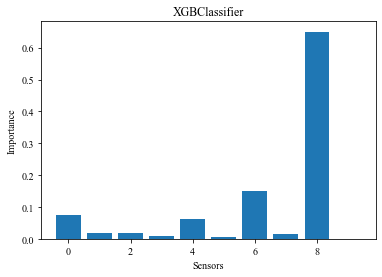

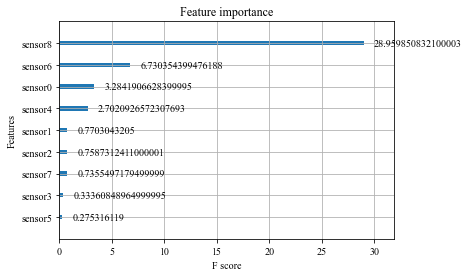

XGBClassifier For sensor8 Predicitve Score is 0.6500527858734131
XGBClassifier For sensor6 Predicitve Score is 0.15107417106628418
XGBClassifier For sensor0 Predicitve Score is 0.07371921092271805
XGBClassifier For sensor4 Predicitve Score is 0.06065303459763527
XGBClassifier For sensor1 Predicitve Score is 0.017290782183408737
XGBClassifier For sensor2 Predicitve Score is 0.017031004652380943
XGBClassifier For sensor7 Predicitve Score is 0.016510656103491783
XGBClassifier For sensor3 Predicitve Score is 0.0074884057976305485
XGBClassifier For sensor5 Predicitve Score is 0.006179935298860073
XGBClassifier For sensor9 Predicitve Score is 0.0


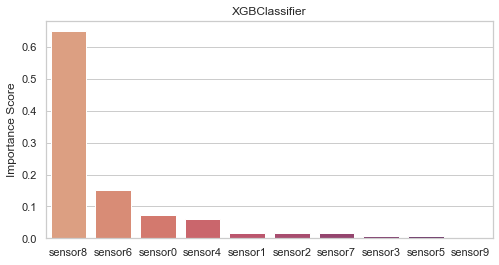

XGBClassifier Mean Absolute Error : 0.025
XGBClassifier Accuracy of Model is : 98.75%
XGBClassifier Threshold = 0.00000, n=10, Accuracy : 98.75%
XGBClassifier Threshold = 0.00618, n=9, Accuracy : 98.75%
XGBClassifier Threshold = 0.00749, n=8, Accuracy : 98.75%
XGBClassifier Threshold = 0.01651, n=7, Accuracy : 98.75%
XGBClassifier Threshold = 0.01703, n=6, Accuracy : 98.75%
XGBClassifier Threshold = 0.01729, n=5, Accuracy : 98.75%
XGBClassifier Threshold = 0.06065, n=4, Accuracy : 98.75%
XGBClassifier Threshold = 0.07372, n=3, Accuracy : 97.50%
XGBClassifier Threshold = 0.15107, n=2, Accuracy : 100.00%
XGBClassifier Threshold = 0.65005, n=1, Accuracy : 83.75%


In [13]:
model_def = model(XGBClassifier, 'XGBClassifier',  X_train, y_train, X_test, y_test)

## Model 2 : Random Forest Classifier

Model Feature Importance [0.18178747 0.02794205 0.05452721 0.04565721 0.18860148 0.01870052
 0.20151385 0.01605333 0.25184209 0.0133748 ]


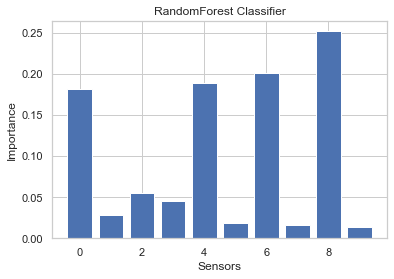

RandomForest Classifier For sensor8 Predicitve Score is 0.25184208560740384
RandomForest Classifier For sensor6 Predicitve Score is 0.20151384786553148
RandomForest Classifier For sensor4 Predicitve Score is 0.18860147957202897
RandomForest Classifier For sensor0 Predicitve Score is 0.18178746669735377
RandomForest Classifier For sensor2 Predicitve Score is 0.05452721406517554
RandomForest Classifier For sensor3 Predicitve Score is 0.04565721111515612
RandomForest Classifier For sensor1 Predicitve Score is 0.02794204889487187
RandomForest Classifier For sensor5 Predicitve Score is 0.018700518985751455
RandomForest Classifier For sensor7 Predicitve Score is 0.016053325275029645
RandomForest Classifier For sensor9 Predicitve Score is 0.01337480192169733


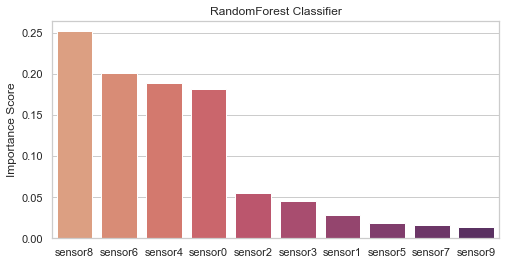

RandomForest Classifier Mean Absolute Error : 0.05
RandomForest Classifier Accuracy of Model is : 97.50%
RandomForest Classifier Threshold = 0.01337, n=10, Accuracy : 98.75%
RandomForest Classifier Threshold = 0.01605, n=9, Accuracy : 98.75%
RandomForest Classifier Threshold = 0.01870, n=8, Accuracy : 98.75%
RandomForest Classifier Threshold = 0.02794, n=7, Accuracy : 98.75%
RandomForest Classifier Threshold = 0.04566, n=6, Accuracy : 98.75%
RandomForest Classifier Threshold = 0.05453, n=5, Accuracy : 98.75%
RandomForest Classifier Threshold = 0.18179, n=4, Accuracy : 98.75%
RandomForest Classifier Threshold = 0.18860, n=3, Accuracy : 100.00%
RandomForest Classifier Threshold = 0.20151, n=2, Accuracy : 100.00%
RandomForest Classifier Threshold = 0.25184, n=1, Accuracy : 83.75%


In [14]:
model_def = model(RandomForestClassifier, 'RandomForest Classifier',  X_train, y_train, X_test, y_test)

## Model 3 : AdaBoost Classifier

Model Feature Importance [0.   0.   0.   0.   0.02 0.   0.96 0.   0.02 0.  ]


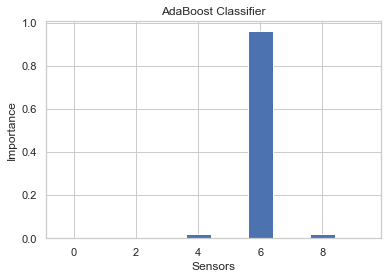

AdaBoost Classifier For sensor6 Predicitve Score is 0.96
AdaBoost Classifier For sensor8 Predicitve Score is 0.02
AdaBoost Classifier For sensor4 Predicitve Score is 0.02
AdaBoost Classifier For sensor9 Predicitve Score is 0.0
AdaBoost Classifier For sensor7 Predicitve Score is 0.0
AdaBoost Classifier For sensor5 Predicitve Score is 0.0
AdaBoost Classifier For sensor3 Predicitve Score is 0.0
AdaBoost Classifier For sensor2 Predicitve Score is 0.0
AdaBoost Classifier For sensor1 Predicitve Score is 0.0
AdaBoost Classifier For sensor0 Predicitve Score is 0.0


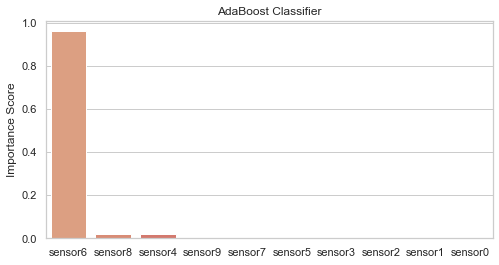

AdaBoost Classifier Mean Absolute Error : 0.0
AdaBoost Classifier Accuracy of Model is : 100.00%
AdaBoost Classifier Threshold = 0.00000, n=10, Accuracy : 98.75%
AdaBoost Classifier Threshold = 0.00000, n=10, Accuracy : 98.75%
AdaBoost Classifier Threshold = 0.00000, n=10, Accuracy : 98.75%
AdaBoost Classifier Threshold = 0.00000, n=10, Accuracy : 98.75%
AdaBoost Classifier Threshold = 0.00000, n=10, Accuracy : 98.75%
AdaBoost Classifier Threshold = 0.00000, n=10, Accuracy : 98.75%
AdaBoost Classifier Threshold = 0.00000, n=10, Accuracy : 98.75%
AdaBoost Classifier Threshold = 0.02000, n=3, Accuracy : 100.00%
AdaBoost Classifier Threshold = 0.02000, n=3, Accuracy : 100.00%
AdaBoost Classifier Threshold = 0.96000, n=1, Accuracy : 100.00%


In [15]:
model_def = model(AdaBoostClassifier, 'AdaBoost Classifier', X_train, y_train, X_test, y_test)